In [ ]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
from pyspark.sql.window import Window 
import datetime




# create sparksession
spark = SparkSession \
    .builder \
    .appName("YelpDataAnalyze") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

 # Create an sql context so that we can query data files in sql like syntax
sqlContext = SQLContext (spark)

In [71]:
tips = sqlContext.read.json ("../input/tip.json")
users = sqlContext.read.json ("../input/user.json")
reviews = sqlContext.read.json ("../input/review.json")
checkins = sqlContext.read.json ("../input/checkin.json")
photos = sqlContext.read.json ("../input/photo.json")
businesses = sqlContext.read.json ("../input/business.json")

In [17]:
tips.createOrReplaceTempView('tips')
users.createOrReplaceTempView('users')
reviews.createOrReplaceTempView('reviews')
checkins.createOrReplaceTempView('checkins')
photos.createOrReplaceTempView('photos')
businesses.createOrReplaceTempView('businesses')

In [18]:
sqlContext.sql(
'''
SELECT * FROM businesses
LIMIT 10
'''
).show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|2818 E Camino Ace...|[,,,,,,,,,,,,,,,,...|1SWheh84yJXfytovI...|   Golf, Active Life|      Phoenix|                null|      0|   33.5221425|   -112.0184807|Arizona Biltmore ...|      85016|           5|  3.0|   AZ|
|30 Eglinton Avenue W|[,, u'full_bar', ...|QXAEGFB4oINsVuTFx...|Specialty Food, R...|  Mississauga|[9:0-1:0, 9:0-0:0...|      1|43.6

In [19]:
businesses.printSchema

<bound method DataFrame.printSchema of DataFrame[address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Frid

In [21]:
businesses.select("attributes.*")

DataFrame[AcceptsInsurance: string, AgesAllowed: string, Alcohol: string, Ambience: string, BYOB: string, BYOBCorkage: string, BestNights: string, BikeParking: string, BusinessAcceptsBitcoin: string, BusinessAcceptsCreditCards: string, BusinessParking: string, ByAppointmentOnly: string, Caters: string, CoatCheck: string, Corkage: string, DietaryRestrictions: string, DogsAllowed: string, DriveThru: string, GoodForDancing: string, GoodForKids: string, GoodForMeal: string, HairSpecializesIn: string, HappyHour: string, HasTV: string, Music: string, NoiseLevel: string, Open24Hours: string, OutdoorSeating: string, RestaurantsAttire: string, RestaurantsCounterService: string, RestaurantsDelivery: string, RestaurantsGoodForGroups: string, RestaurantsPriceRange2: string, RestaurantsReservations: string, RestaurantsTableService: string, RestaurantsTakeOut: string, Smoking: string, WheelchairAccessible: string, WiFi: string]

In [24]:
businesses.select("hours.Friday").show()

+----------+
|    Friday|
+----------+
|      null|
|   9:0-1:0|
|17:30-22:0|
|  8:0-17:0|
|  7:0-23:0|
|  9:0-19:0|
|      null|
| 10:0-19:0|
| 10:0-17:0|
|  9:0-19:0|
|  9:0-17:0|
|   7:0-1:0|
|  10:0-1:0|
|  10:0-1:0|
| 11:0-17:0|
|16:0-21:30|
|  8:0-17:0|
|      null|
|   0:0-0:0|
|  6:0-22:0|
+----------+
only showing top 20 rows



In [25]:
sqlContext.sql(
'''SELECT COUNT(review_id)
FROM reviews
WHERE useful > 0 and funny > 0 and cool > 0'''
).show()

+----------------+
|count(review_id)|
+----------------+
|          873302|
+----------------+



In [26]:
reviews.count()

6685900

In [27]:
sqlContext.sql(
'''SELECT review_id, SUM(coalesce(useful, 0) + coalesce(funny,0) + coalesce(cool, 0)) as total_votes
FROM reviews
GROUP BY review_id
order by 2 desc
limit 1'''
).show()

+--------------------+-----------+
|           review_id|total_votes|
+--------------------+-----------+
|A8mLBytNM2zmjHgSp...|       2256|
+--------------------+-----------+



In [31]:
sqlContext.sql(
'''SELECT b.business_id, name as business_name,  count(*) as no_of_reviews
FROM reviews r
JOIN businesses b
ON r.business_id = b.business_id
group by b.business_id, b.name
order by 3 desc
limit 20'''
).show()

+--------------------+--------------------+-------------+
|         business_id|       business_name|no_of_reviews|
+--------------------+--------------------+-------------+
|4JNXUYY8wbaaDmk3B...|        Mon Ami Gabi|         8570|
|RESDUcs7fIiihp38-...|    Bacchanal Buffet|         8568|
|K7lWdNUhCbcnEvI0N...|        Wicked Spoon|         6887|
|f4x1YBxkLrZg652xt...|  Hash House A Go Go|         5847|
|cYwJA2A6I12KNkm2r...| Gordon Ramsay BurGR|         5575|
|DkYS3arLOhA8si5uU...|    Earl of Sandwich|         5206|
|2weQS-RnoOBhb1KsH...|          The Buffet|         4534|
|5LNZ67Yw9RD6nf4_U...|The Cosmopolitan ...|         4522|
|iCQpiavjjPzJ5_3gP...|        Secret Pizza|         4351|
|SMPbvZLSMMb7KU76Y...|ARIA Resort & Casino|         4350|
|ujHiaprwCQ5ewziu0...|The Buffet at Bel...|         4318|
|AV6weBrZFFBfRGCbc...|Luxor Hotel and C...|         4240|
|KskYqH1Bi7Z_61pH6...|       Lotus of Siam|         4131|
|El4FC8jcawUVgw_0E...|     MGM Grand Hotel|         4093|
|rcaPajgKOJC2v

Text(0.5, 1.0, 'Top 20 business who received highest reviews with their respective review count')

<Figure size 432x288 with 0 Axes>

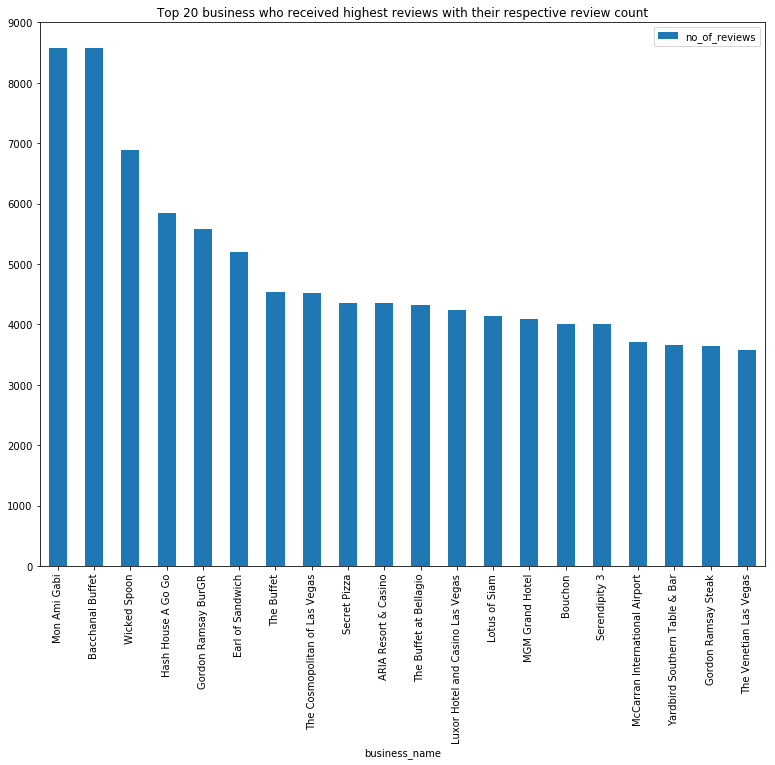

In [44]:
plt.clf()
top_20_businesses = sqlContext.sql(
'''SELECT b.business_id, name as business_name,  count(*) as no_of_reviews
FROM reviews r
JOIN businesses b
ON r.business_id = b.business_id
group by b.business_id, b.name
order by 3 desc
limit 20'''
).toPandas();
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(13)
top_20_businesses.plot(x='business_name', y='no_of_reviews', ax = ax, kind="bar")
plt.title('Top 20 business who received highest reviews with their respective review count')




<Figure size 432x288 with 0 Axes>

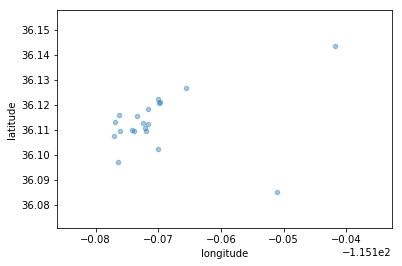

In [74]:
plt.clf()
top_20_businesses_locations = sqlContext.sql(
'''SELECT b.business_id, name as business_name, latitude, longitude, count(*) as no_of_reviews
FROM reviews r
JOIN businesses b
ON r.business_id = b.business_id
group by b.business_id, b.name, b.latitude, b.longitude
order by no_of_reviews desc
limit 20'''
).toPandas()
top_20_businesses_locations.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.show()

In [103]:
businesses_moving_avg_month = sqlContext.sql("""select business_id, month,avg(total_reviews)                                       
                                          over (partition by business_id, month order by month)
                                          as total
                                from (select business_id, month(date) as month, count(*) as total_reviews
                                from reviews
                                group by business_id, month(date)) r
                                order by business_id, month""")
businesses_moving_avg_month.show()

+--------------------+-----+-----+
|         business_id|month|total|
+--------------------+-----+-----+
|--1UhMGODdWsrMast...|    1|  1.0|
|--1UhMGODdWsrMast...|    2|  1.0|
|--1UhMGODdWsrMast...|    4|  3.0|
|--1UhMGODdWsrMast...|    5|  5.0|
|--1UhMGODdWsrMast...|    6|  5.0|
|--1UhMGODdWsrMast...|    7|  3.0|
|--1UhMGODdWsrMast...|    8|  3.0|
|--1UhMGODdWsrMast...|    9|  1.0|
|--1UhMGODdWsrMast...|   11|  1.0|
|--1UhMGODdWsrMast...|   12|  3.0|
|--6MefnULPED_I942...|    1|  6.0|
|--6MefnULPED_I942...|    2|  4.0|
|--6MefnULPED_I942...|    4|  2.0|
|--6MefnULPED_I942...|    5|  4.0|
|--6MefnULPED_I942...|    7|  4.0|
|--6MefnULPED_I942...|    8|  8.0|
|--6MefnULPED_I942...|    9|  4.0|
|--6MefnULPED_I942...|   10|  4.0|
|--6MefnULPED_I942...|   11|  4.0|
|--6MefnULPED_I942...|   12|  6.0|
+--------------------+-----+-----+
only showing top 20 rows



In [109]:
business_yoy_reviews_comparision = sqlContext.sql("""select b.business_id, b.name as business_name, year(date) as year, r.stars, count(*) as total_reviews
from reviews r
join businesses b
on b.business_id = r.business_id
where r.stars>4
group by b.business_id, name, year(date), r.stars
order by b.business_id, year desc, total_reviews desc""")
business_yoy_reviews_comparision.show()


+--------------------+--------------------+----+-----+-------------+
|         business_id|       business_name|year|stars|total_reviews|
+--------------------+--------------------+----+-----+-------------+
|--1UhMGODdWsrMast...|    The Spicy Amigos|2018|  5.0|            2|
|--1UhMGODdWsrMast...|    The Spicy Amigos|2017|  5.0|            7|
|--1UhMGODdWsrMast...|    The Spicy Amigos|2016|  5.0|            4|
|--6MefnULPED_I942...|John's Chinese BB...|2018|  5.0|            3|
|--6MefnULPED_I942...|John's Chinese BB...|2017|  5.0|            2|
|--6MefnULPED_I942...|John's Chinese BB...|2016|  5.0|            2|
|--6MefnULPED_I942...|John's Chinese BB...|2015|  5.0|            1|
|--6MefnULPED_I942...|John's Chinese BB...|2008|  5.0|            1|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2018|  5.0|            7|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2017|  5.0|            6|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2016|  5.0|            7|
|--7zmmkVg-IMGaXbu...|      Primal

In [ ]:
business_pd = business_yoy_reviews_comparision.nlargest(20).toPandas()
for business_id in business_pd:
    #print(business_pd["business_id"])
    series = pd.Series(business_pd["total_reviews"].values, index=business_pd["year"].values, name='Trending business')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_pd["business_name"]), axes=axes)
    plt.show()


In [108]:
business_yoy_reviews_comparision = sqlContext.sql("""select b.business_id, b.name as business_name, year(date) as year, r.stars, count(*) as total_reviews
from reviews r
join businesses b
on b.business_id = r.business_id
where r.stars>4 and r.business_id like 'vHz2RLtfUMVRPFmd7%'
group by b.business_id, name, year(date), r.stars
order by year desc, total_reviews desc""")
business_yoy_reviews_comparision.show()

+--------------------+--------------------+----+-----+-------------+
|         business_id|       business_name|year|stars|total_reviews|
+--------------------+--------------------+----+-----+-------------+
|vHz2RLtfUMVRPFmd7...|Gordon Ramsay Hel...|2018|  5.0|         1396|
+--------------------+--------------------+----+-----+-------------+



In [116]:
d = datetime.datetime.today()
day_dic={0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',}

print(day_dic.get(int(d.strftime("%w"))))

Tuesday


In [131]:
business_hours = sqlContext.sql("""select business_id, split(hours.Friday, '-') from businesses where split(hours.Friday, '-')[0] is not null""")
business_hours.show()

+--------------------+----------------------------------+
|         business_id|split(hours.Friday AS `Friday`, -)|
+--------------------+----------------------------------+
|QXAEGFB4oINsVuTFx...|                        [9:0, 1:0]|
|gnKjwL_1w79qoiV3I...|                     [17:30, 22:0]|
|xvX2CttrVhyG2z1dF...|                       [8:0, 17:0]|
|HhyxOkGAM07SRYtlQ...|                       [7:0, 23:0]|
|68dUKd8_8liJ7in4a...|                       [9:0, 19:0]|
|gbQN7vr_caG_A1ugS...|                      [10:0, 19:0]|
|Y6iyemLX_oylRpnr3...|                      [10:0, 17:0]|
|4GBVPIYRvzGh4K4Tk...|                       [9:0, 19:0]|
|fcXOEZdXYeZqnQ3lG...|                       [9:0, 17:0]|
|1Dfx3zM-rW4n-31Ke...|                        [7:0, 1:0]|
|5t3KVdMnFgAYmSl1w...|                       [10:0, 1:0]|
|fweCYi8FmbJXHCqLn...|                       [10:0, 1:0]|
|-K4gAv8_vjx8-2Bxk...|                      [11:0, 17:0]|
|A98xW4qb7vOTguggH...|                     [16:0, 21:30]|
|giC3pVVFxCRR8

In [155]:
#Select all business names which are open on Friday from 6 to 12 Midnight
business_hours = sqlContext.sql("""select b.*, stars, total_reviews from 
(select business_id, name as business_name, latitude, longitude, hours.Friday
from businesses
where int(split(split(hours.Friday, '-')[0], ':')[0]) < 6 and int(split(split(hours.Friday, '-')[0], ':')[1]) <= 0
and int(split(split(hours.Friday, '-')[1], ':')[0]) >= 0) b
join (select business_id, stars, count(*) as total_reviews from reviews where stars > 4 group by business_id, stars) r
on b.business_id = r.business_id
order by total_reviews desc""")
business_hours.show()

+--------------------+--------------------+-------------+---------------+--------+-----+-------------+
|         business_id|       business_name|     latitude|      longitude|  Friday|stars|total_reviews|
+--------------------+--------------------+-------------+---------------+--------+-----+-------------+
|DkYS3arLOhA8si5uU...|    Earl of Sandwich|    36.109418|   -115.1718738| 0:0-0:0|  5.0|         2645|
|f4x1YBxkLrZg652xt...|  Hash House A Go Go|36.1181806906|-115.1715797813| 0:0-0:0|  5.0|         2382|
|5LNZ67Yw9RD6nf4_U...|The Cosmopolitan ...|   36.1097553|   -115.1738769| 0:0-0:0|  5.0|         2056|
|JDZ6_yycNQFTpUZzL...|   El Dorado Cantina|36.1349154274|-115.1758220047| 0:0-0:0|  5.0|         1966|
|awI4hHMfa7H0Xf0-C...|      The Oyster Bar|36.1431362393|-115.1747075477| 0:0-0:0|  5.0|         1621|
|Wxxvi3LZbHNIDwJ-Z...|The Venetian Las ...|    36.121189|    -115.169657| 0:0-0:0|  5.0|         1563|
|t-o_Sraneime4DDhW...|      Wynn Las Vegas|    36.127684|    -115.165905|

In [ ]:
categories = sqlContext.sql("""select business_id, categories from businesses""")
categories.show(10, False)